In [28]:
import pandas as pd
import seaborn

df = pd.read_csv("../Donnees/cleaned_data.csv")


<Axes: ylabel='Frequency'>

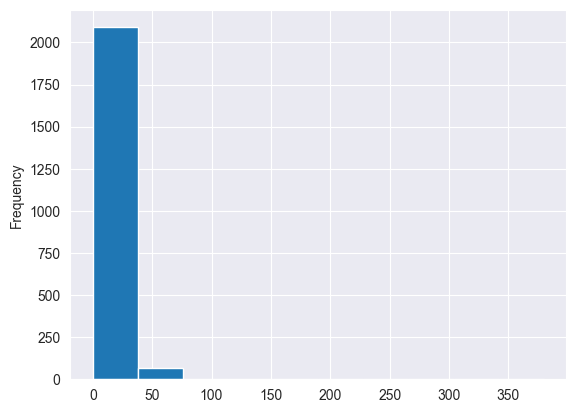

In [29]:
df["price"].plot.hist()

<Axes: >

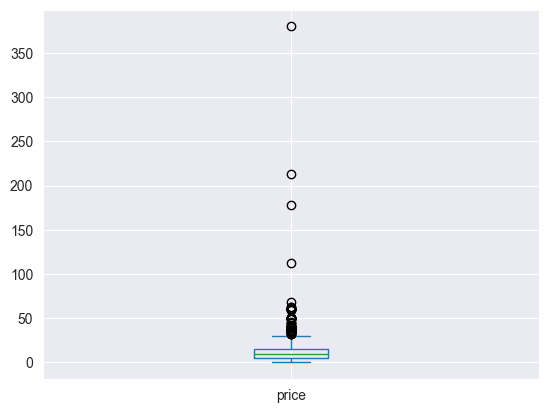

In [30]:
df["price"].plot.box()

In [31]:
number_columns = ["rating", "retirement", "time", "price", "review_count", "rating_value", "twenty_four_hours", "all_time"]
dfn = df[number_columns]

In [32]:
from sklearn.ensemble import IsolationForest

forest = IsolationForest()
outliers = forest.fit_predict(dfn)



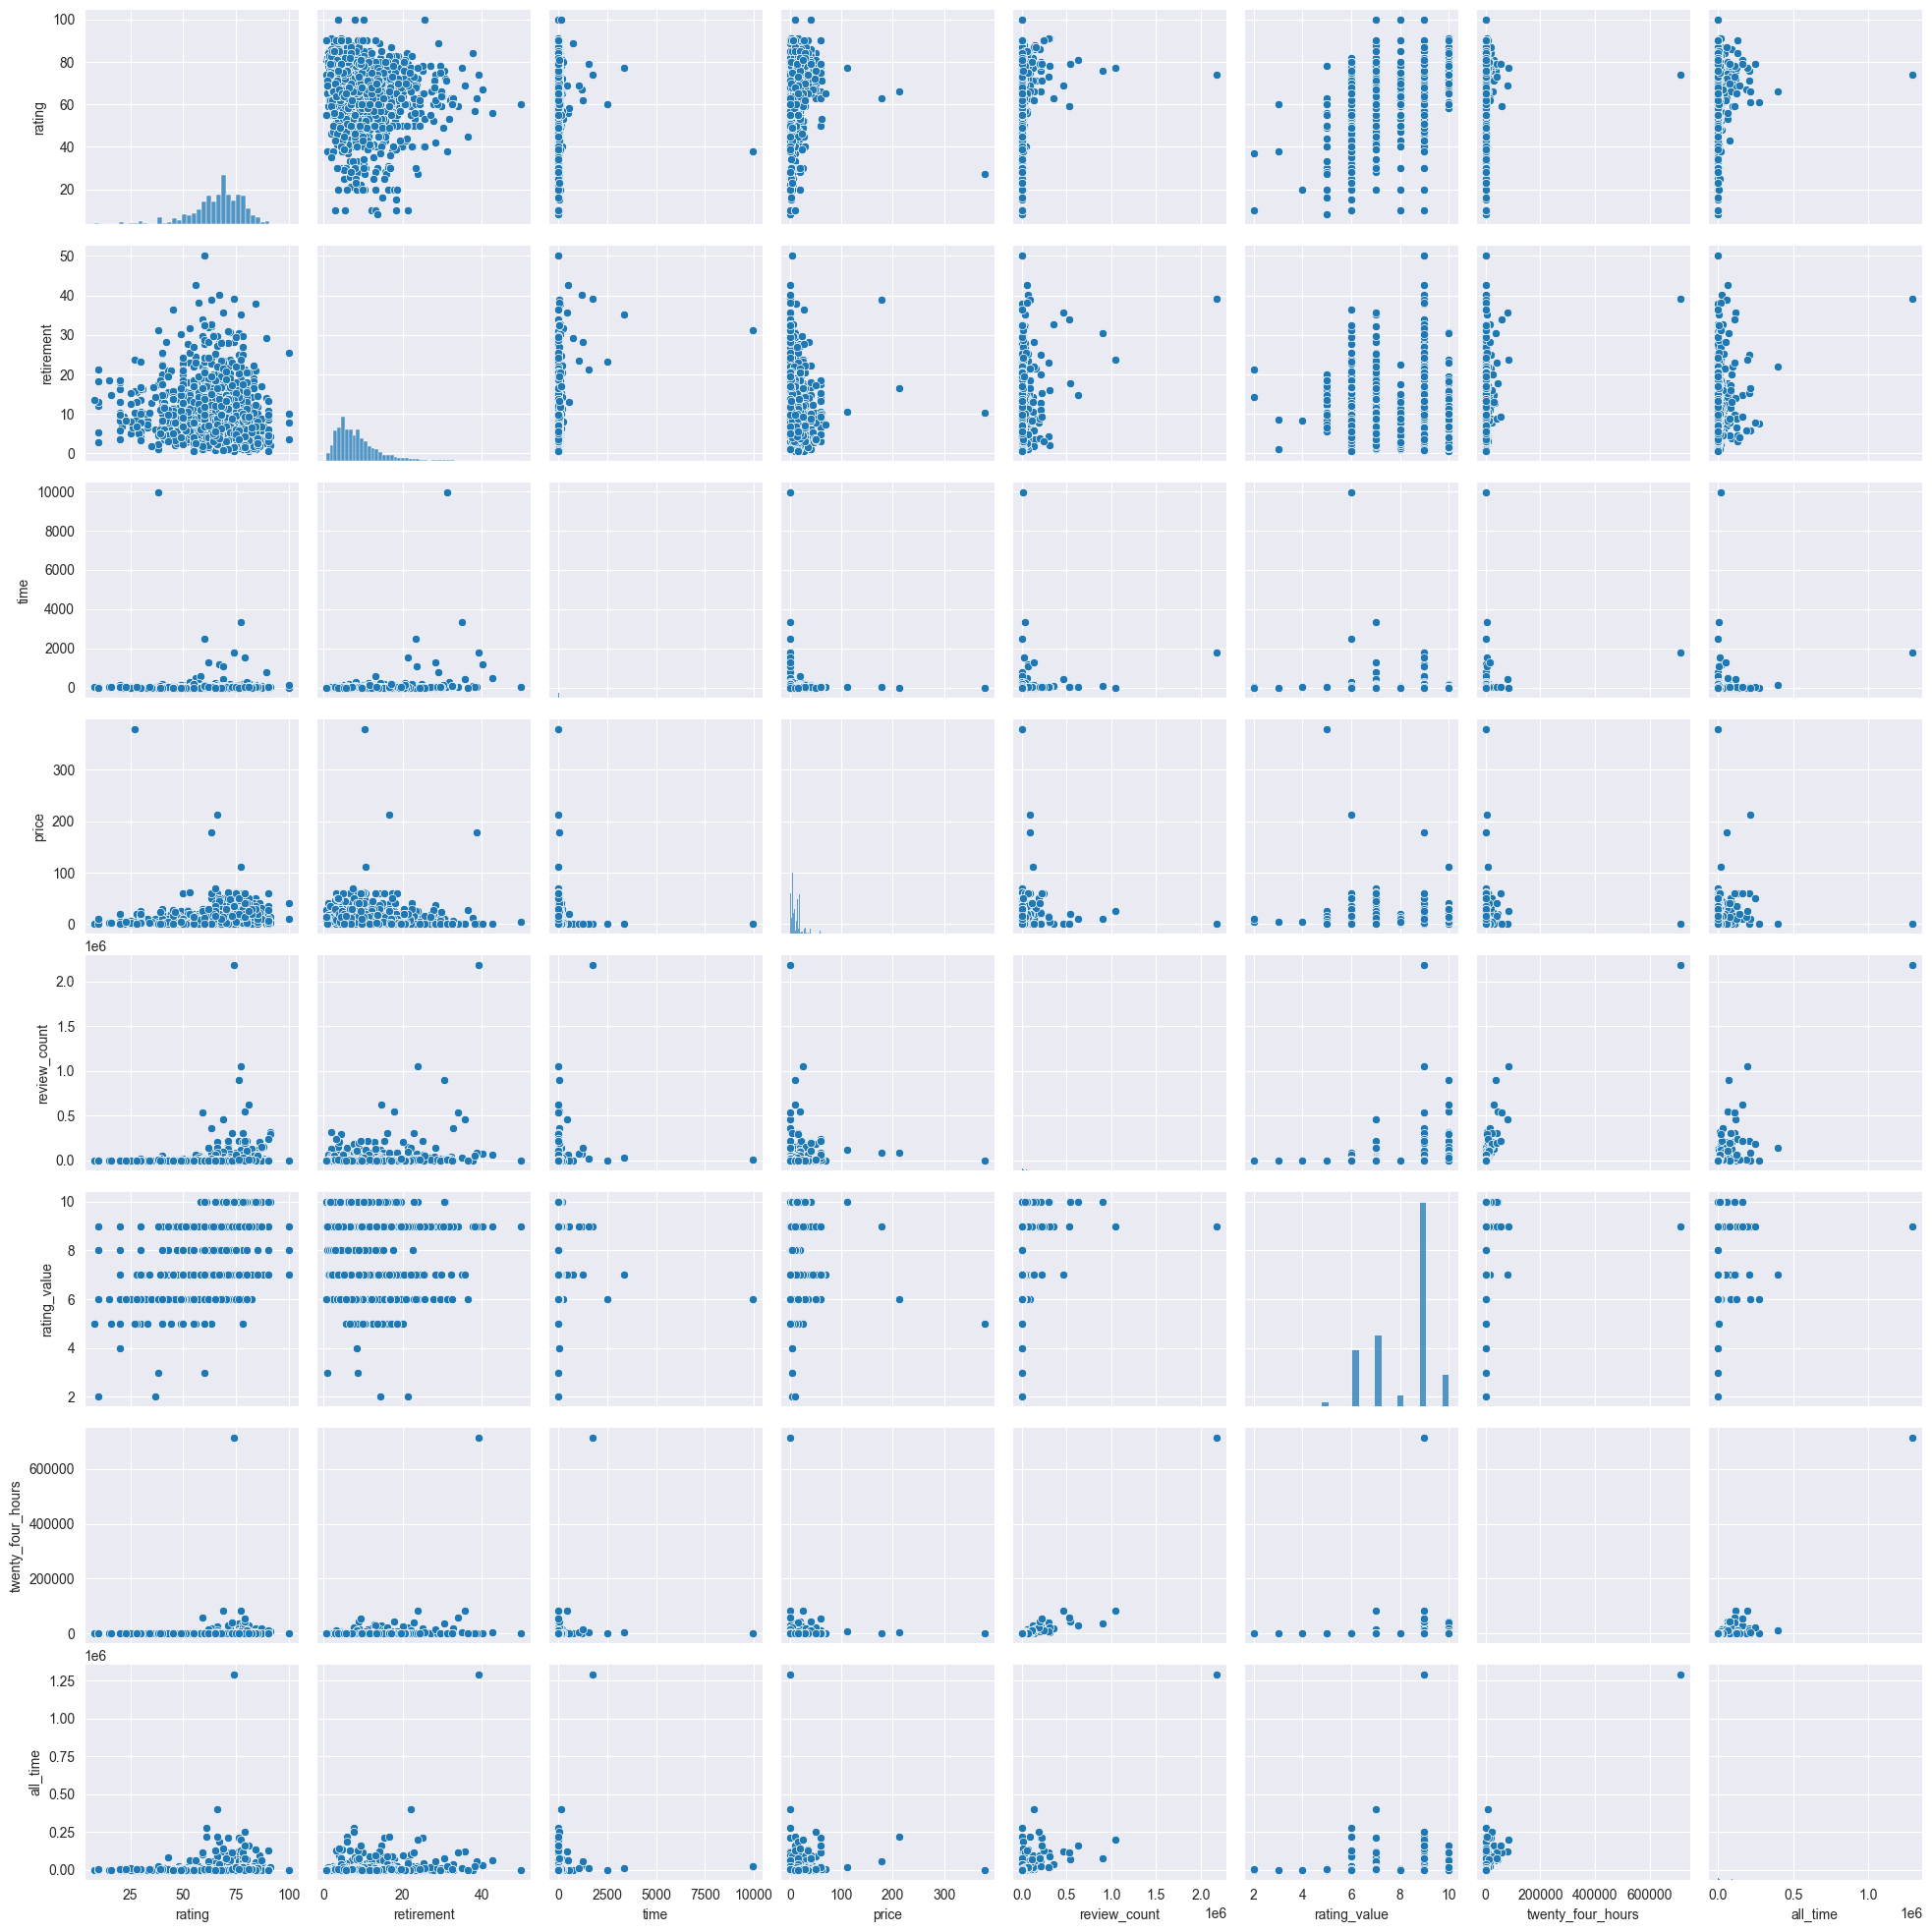

In [33]:
import numpy as np

dfn.drop(index=np.where(outliers==-1)[0])

seaborn.pairplot(dfn)

(array([  52,   80,  114,  125,  152,  177,  179,  180,  213,  222,  244,
         247,  250,  251,  300,  315,  358,  367,  374,  404,  433,  448,
         453,  454,  459,  501,  562,  582,  587,  607,  647,  672,  719,
         749,  750,  755,  764,  766,  806,  817,  818,  905,  906,  913,
         942,  943, 1006, 1009, 1017, 1038, 1039, 1048, 1053, 1084, 1110,
        1121, 1125, 1150, 1167, 1199, 1200, 1223, 1224, 1226, 1247, 1295,
        1304, 1309, 1314, 1317, 1319, 1335, 1337, 1353, 1363, 1374, 1382,
        1408, 1410, 1464, 1472, 1474, 1491, 1495, 1505, 1513, 1537, 1567,
        1576, 1589, 1595, 1598, 1604, 1609, 1637, 1642, 1645, 1647, 1673,
        1679, 1693, 1718, 1748, 1762, 1787, 1799, 1805, 1823, 1829, 1860,
        1871, 1882, 1892, 1903, 1914, 1947, 1981, 1992, 2004, 2016, 2018,
        2034, 2066, 2072, 2074, 2076, 2084, 2096, 2098, 2114, 2146, 2152,
        2154, 2156]),)